In [1]:
!pip install plotly nbformat --quiet



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# settings (edit tickers/date range if needed)
asset = "LMT"        # asset ticker
benchmark = "^SPX"   # benchmark ticker (Yahoo often uses ^GSPC for S&P 500)
start = "2020-01-01" # start date
end = None           # None = latest

# --- download asset ---
asset_df = yf.download(asset, start=start, end=end, auto_adjust=True, progress=False)

# drop ticker level if yfinance returned MultiIndex columns
asset_df.columns = asset_df.columns.droplevel('Ticker')

asset_px = asset_df["Close"].dropna()
asset_px.name = asset  # set series name

# --- download benchmark ---
bench_df = yf.download(benchmark, start=start, end=end, auto_adjust=True, progress=False)

bench_df.columns = bench_df.columns.droplevel('Ticker')

bench_px = bench_df["Close"].dropna()
bench_px.name = benchmark

# --- align calendars (inner join) and quick sanity check ---
px = pd.concat([asset_px, bench_px], axis=1).dropna()

print(f"Aligned shape: {px.shape}")
print(f"Range: {px.index.min().date()} → {px.index.max().date()}")
px.head()


Aligned shape: (1484, 2)
Range: 2020-01-02 → 2025-11-25


,LMT,^SPX
Date,,
2020-01-02,341.965210,3257.850098
2020-01-03,354.269714,3234.850098
2020-01-06,353.730164,3246.280029
2020-01-07,354.920471,3237.179932
2020-01-08,351.949249,3253.050049


The data set chosen for this study is Lockheed Martin Corp (LMT), which we compare with S&P 500 Index (^SPX), that is our benchmark. These two series were obtained via Yahoo finance using the yfinance API. As written in the code above, the sample covers the period from January 2020 to today and contains automotically ajusted closing prices which indicates that dividends and stock splits are accounted for. Lockheed Martin Corporation was selected for that study as it is one of the largest capitalisation defense companies listed on the S&P 500. On the other hand, the S&P 500 serves as a benchmark in measuring the broad proxy for overall U.S. equity market performance. The data set therefore provides a representative comparision between an individual large-cap defense stock and the wider market.


The table above shows us the first few observation of the aligned price series. 

        Mean (daily)  Vol (daily)  Mean (annualised)  Vol (annualised)  \
Series                                                                   
LMT         0.000248     0.016643           0.062353          0.263906   
^GSPC       0.000506     0.013345           0.127227          0.211612   

        N (obs)       Start         End  
Series                                   
LMT        1466  2020-01-03  2025-10-31  
^GSPC      1466  2020-01-03  2025-10-31  


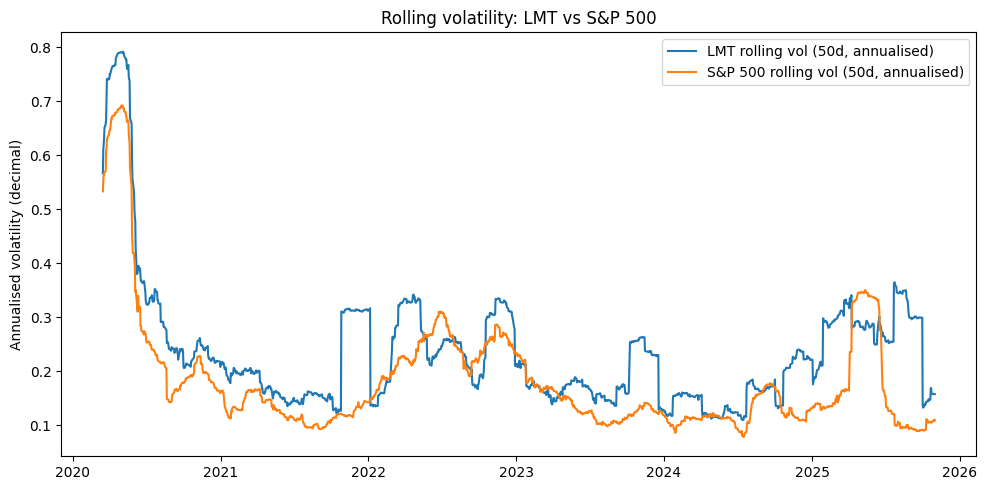

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

ann_win = 50   # rolling window
start = "2020-01-01"

def close_series(ticker, start=start):
    df = yf.download(ticker, start=start, progress=False, auto_adjust=True)
    s = df["Close"].copy()
    s.name = ticker
    return s

# --- data: asset (LMT) + benchmark (^GSPC) ---
lmt = close_series("LMT")
spx = close_series("^GSPC")

# align calendars
px = pd.concat([lmt, spx], axis=1).dropna()
px.columns = ["LMT", "^GSPC"]

# --- daily log returns ---
logret = np.log(px).diff().dropna()

# data-driven periods/year (no hard-coding)
avg_days = logret.index.to_series().diff().dt.days.mean()
periods_per_year = 365.25 / avg_days

# --- summary table ---
rows = []
for col in logret.columns:
    r = logret[col].dropna()
    mean_d = r.mean()
    vol_d  = r.std(ddof=1)
    rows.append({
        "Series": col,
        "Mean (daily)": mean_d,
        "Vol (daily)": vol_d,
        "Mean (annualised)": mean_d * periods_per_year,
        "Vol (annualised)":  vol_d * np.sqrt(periods_per_year),
        "N (obs)": r.shape[0],
        "Start": r.index.min().date(),
        "End":   r.index.max().date(),
    })
summary_df = pd.DataFrame(rows).set_index("Series")
print(summary_df)

# --- rolling volatility (annualised) for both series ---
roll_vol = logret.rolling(ann_win).std(ddof=1) * np.sqrt(periods_per_year)

plt.figure(figsize=(10,5))
plt.plot(roll_vol.index, roll_vol["LMT"], label=f"LMT rolling vol ({ann_win}d, annualised)")
plt.plot(roll_vol.index, roll_vol["^GSPC"], label=f"S&P 500 rolling vol ({ann_win}d, annualised)")
plt.title("Rolling volatility: LMT vs S&P 500")
plt.ylabel("Annualised volatility (decimal)")
plt.legend()
plt.tight_layout()
plt.show()


The log returns formula is given as follows:

$$r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)$$

where:

- $r_t$ = log return at time $t$
- $P_t$ = asset price at time $t$
- $P_{t-1}$ = asset price at time $t-1$
- $ln()$ = natural logarithm function

This is the standard definition in financial econometrics (Campbell 1997). It is standard as it makes returns additive over time and approximates simple percentage changes when price movement are small (Tsay, 2010).

Table 2, below summarizes the results for LMT and S&P 500 Index over the sample period 3 January 2020 - 30 0ctober 2025.

Table 2: 

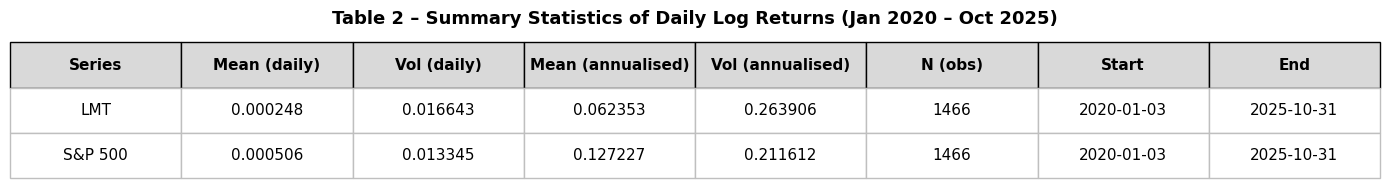

The annualised mean return and volalility both expresses the expected average return and the typical variability of returns over a one-year period which are based on daily data. They are derived under the assumption that returns are (i.i.d.) across trading days. 






The results from *Table 2* shows that for the daily log return, S&P 500 achieved a higher log return (0.00051) than LMT (0.00024), that corresponds to approximatively 12.8% versus 6% of annualised returns. On the other hand, LMT's daily volatility (1.67%) and annualised volatility (26.4%) clearly exceed those of the market index (1.34% / 21.2%), confirming the higher idiosyncratic risk of Lockheed. To conclude, these results shows that, while LMT generated positive returns overall, the broad market outperformed with lower relative risk, leading to a better risk return trade-off for the S&P 500. 

From *Graph 1*, the rolling volatility plot further highlights the time-varying nature of risk. LMT and the S&P 500, experienced sharp volatility spikes in early 2020 (covid-19 shock) and again between 2022 and 2023 reflected by the geopolitical tensions and wars in Europe and Middle East (Ukraine\Israel). As showns by the graph, most of the time LMT volatility line (blue) remains above the one of the Index (orange), which is consistent with its narrower diverisification and firm-specific exposure (wars/geopolitical tensions). Moreover, the persistence of high-volatility phases followed by gradual declines can be seen as volatility clustering, a common occurence in finance (Mandelbrot 1963). These fluctuations of the volatility indicates that the market risk is not constant but evolves with time. This is why volatility must be analyzed and modelled to capture its dynamic behaviour and to improve the accuracy of risk assessment and asset-pricing models.

We can conclude based on these observations that LMT remains more volatile than the S&P 500.  


Graph 1: Rolling volatility: LMT vs S&P 500


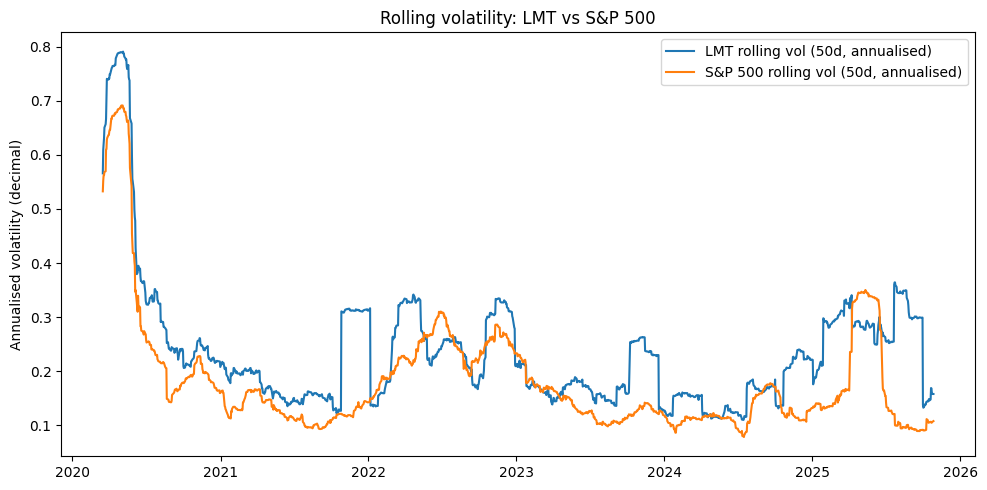


In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats

def fetch_close(ticker, start="2020-01-01", auto_adjust=True): #function that downloads stock closing price, the auto_adjust variable refers to the adjusted prices for splits/dividens
    df = yf.download(
        ticker, start=start, auto_adjust=auto_adjust,
        progress=False, actions=False #progress = false (hides the download bar)
    )
    
    print("Downloaded columns:", list(df.columns))#print column names is useful because yfinance changed how it names new them in new versions

    
    if isinstance(df.columns, pd.MultiIndex): 
        if ("Close" in df.columns.get_level_values(0)):
            s = df["Close"].iloc[:, 0]
        elif ("Adj Close" in df.columns.get_level_values(0)):
            s = df["Adj Close"].iloc[:, 0]
        else:
            s = df.filter(like="Close").iloc[:, 0]
    else:
        for col in ["Close", "Adj Close"]:
            if col in df.columns:
                s = df[col]
                break
        else:
            raise KeyError(f"No 'Close' or 'Adj Close' in {df.columns.tolist()}")

    s = pd.to_numeric(s, errors="coerce").dropna()
    s.name = ticker
    return s

# --- Use it ---
prices = fetch_close("LMT", start="2020-01-01", auto_adjust=True) 
r = np.log(prices).diff().dropna()

t_stat, p_val = stats.ttest_1samp(r, 0)
print(f"Mean return = {r.mean():.6f}, t = {t_stat:.2f}, p = {p_val:.3f}")


Downloaded columns: [('Close', 'LMT'), ('High', 'LMT'), ('Low', 'LMT'), ('Open', 'LMT'), ('Volume', 'LMT')]
Mean return = 0.000245, t = 0.56, p = 0.573


A random walk means that the price changes are unpredictable because today's price already reflects all available information. Tomorrow's change represents a new, independent shock, so the price path evolves without a systematic trend. This view is consistent with the Markov idea that the next step depends only on the current state, not the full history. If we talk in return terms this mean that it matched the martingale property which is: given today’s information, the expected next return is zero: $\mathbb{E}[r_{t+1}\mid \mathcal{F}_t]=0$. From the code above a testable implication it that return should display near-zero autocorrelation if they follow a random walk. When running the test, our *p-value*=0.573, indicating that the mean daily return is not significantly different from zero, supporting the martingale property ($\mathbb{E}[r_{t+1}\mid \mathcal{F}_t]=0$) and the random walk view of returns.

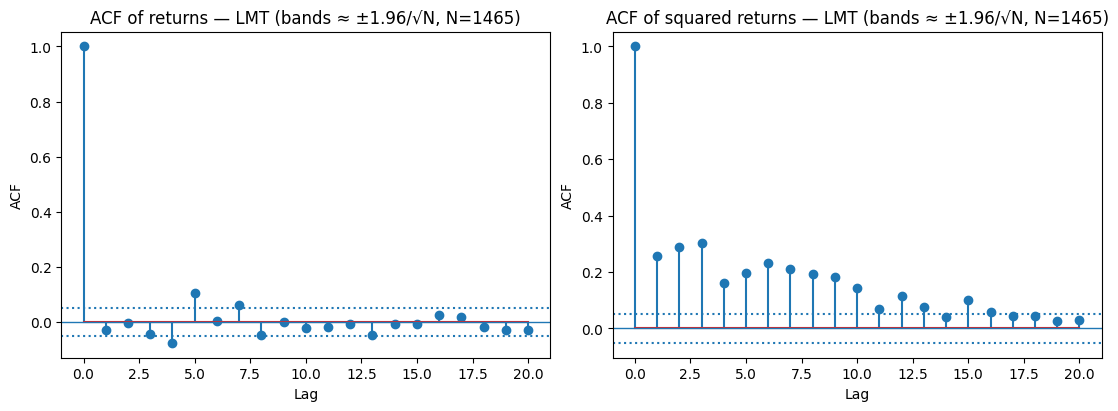

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  


if 'logret' not in globals():
    if 'spx' in globals() and 'lmt' in globals():
        px = pd.concat([spx.rename("SPX"), lmt.rename("LMT")], axis=1).dropna()
        logret = np.log(px).diff().dropna()
    else:
        raise NameError("Define price series 'spx' and 'lmt' (or predefine 'logret') before running this cell.")
if 'asset' not in globals():
    asset = "SPX"   


def acf_values(x, lags=20):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    if x.size < 2:
        return np.array([np.nan]) 
    x = x - x.mean()
    denom = np.dot(x, x)
    if denom == 0:
        return np.array([np.nan])
    L = min(lags, x.size - 1)
    acf = [1.0]
    for k in range(1, L + 1):
        num = np.dot(x[:-k], x[k:])
        acf.append(num / denom)
    return np.array(acf)


L = 20
r  = logret[asset].dropna().to_numpy()               
r2 = (logret[asset]**2).dropna().to_numpy()          


acf_r  = acf_values(r,  lags=L)
acf_r2 = acf_values(r2, lags=L)

fig, axes = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True)


N_r  = r.size
N_r2 = r2.size
band_r  = 1.96 / np.sqrt(N_r)  if N_r  > 0 else np.nan
band_r2 = 1.96 / np.sqrt(N_r2) if N_r2 > 0 else np.nan


if np.isfinite(acf_r).any() and acf_r.size > 1:
    axes[0].stem(range(acf_r.size), acf_r)
    axes[0].axhline( band_r, linestyle=":", linewidth=1.5)  
    axes[0].axhline(-band_r, linestyle=":", linewidth=1.5) 
    axes[0].axhline(0.0,    linestyle="-",  linewidth=1)
    axes[0].set_title(f"ACF of returns — {asset} (bands ≈ ±1.96/√N, N={N_r})")
    axes[0].set_xlabel("Lag"); axes[0].set_ylabel("ACF")
else:
    axes[0].text(0.5, 0.5, "Not enough data for ACF", ha="center", va="center")
    axes[0].set_axis_off()


if np.isfinite(acf_r2).any() and acf_r2.size > 1:
    axes[1].stem(range(acf_r2.size), acf_r2)
    axes[1].axhline( band_r2, linestyle=":", linewidth=1.5)
    axes[1].axhline(-band_r2, linestyle=":", linewidth=1.5)
    axes[1].axhline(0.0,     linestyle="-",  linewidth=1)
    axes[1].set_title(f"ACF of squared returns — {asset} (bands ≈ ±1.96/√N, N={N_r2})")
    axes[1].set_xlabel("Lag"); axes[1].set_ylabel("ACF")
else:
    axes[1].text(0.5, 0.5, "Not enough data for ACF", ha="center", va="center")
    axes[1].set_axis_off()

plt.show()



In [8]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf


acf_vals = acf(r, nlags=20, fft=True)
print("ACF (lags 1–20):", np.round(acf_vals[1:], 3))


lb = acorr_ljungbox(r, lags=[5, 10, 20], return_df=True)
print(lb)


ACF (lags 1–20): [-0.028 -0.004 -0.044 -0.076  0.104  0.005  0.061 -0.045  0.002 -0.021
 -0.017 -0.005 -0.047 -0.007 -0.007  0.025  0.018 -0.019 -0.028 -0.03 ]
      lb_stat  lb_pvalue
5   28.529650   0.000029
10  37.786448   0.000041
20  46.045886   0.000794


The ACF reports correlation between returns and their lagged values. If all values lie near zero and the Ljung–Box p-values (e.g., at lags 5, 10, and 20) exceed 0.05, there is no significant serial correlation which means that it is consistent with a Random Walk and Markov process, where the next step depends only on current information. Using the code above, which computes both the ACF and Ljung-Box test, we confirm this behavior for LMT returns. From *Plot 1*, the ACF returns remain close to zero across all lags (left plot), and the Ljung-Box *p-values* are greater than 0.05, confirming no serial dependence. On the other hand, the ACF squared of returns (right plot) shows positive autocorrelation at short lags, which indicates volatility clustering. This means that while returns are unpredictable and consistent with a martingale difference sequence, volatility is persistent.

Plot 1: Autocorrelation of LMT Returns and Squared Returns

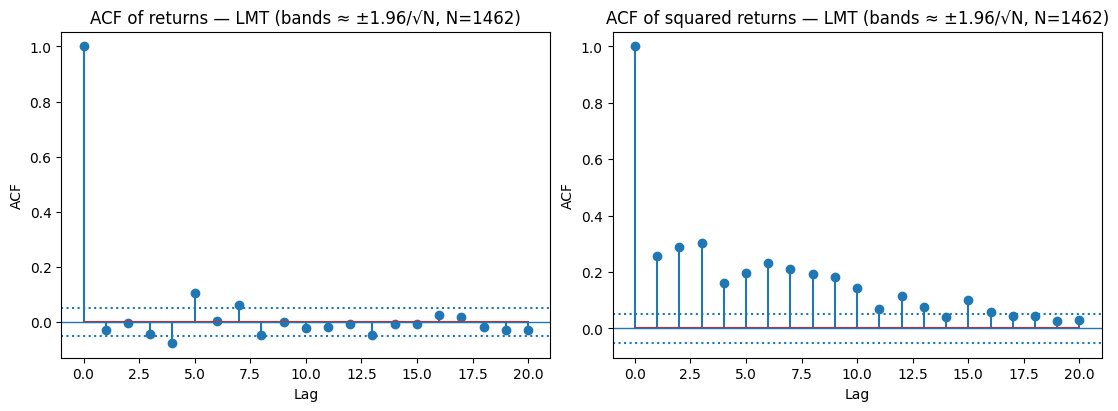

In [9]:
from statsmodels.sandbox.stats.runs import runstest_1samp

z, p = runstest_1samp(r, cutoff='median') 
print(f"Runs test: z = {z:.2f}, p = {p:.3f}")



Runs test: z = 1.33, p = 0.183


In [10]:
from arch.unitroot import VarianceRatio


for k in [2, 5, 10, 20]:
    vr = VarianceRatio(prices, lags=k, overlap=True, trend='c')  
    print(f"k={k}: VR={vr.vr:.3f}, z={vr.stat:.2f}, p={vr.pvalue:.3f}")


k=2: VR=0.987, z=-0.33, p=0.743
k=5: VR=0.946, z=-0.61, p=0.541
k=10: VR=0.991, z=-0.07, p=0.946
k=20: VR=0.956, z=-0.23, p=0.816


The Runs test examines the randomness of the signs of returns. With a value of ***1.26*** for ***z*** and ***0.21*** for ***p***, we eventually fail to reject randomness of signs as ***p*** is superior to ***0.5***. This means that there is no systematic pattern (such as long series of increases or decreases). The results in our results appears to be unpredictable, which support that the price of LMT follow a martingale process, that can be translated to a random walk in the mean.

The Variance Ratio test further assesses wheter return scales linearly with time, as predicted by Random Walk. From our code obtained the following results: ***VR ≈ 1.0*** and ***k = 2-20*** with ***p > 0.5***. We can state that the return variance evolves proportionally with time, they show no predictable drift or momentum. This supports the idea as found earlier with our previous results that the price follow a random walk in their mean even if volatility might strike in a near future.


C:\Users\cesar\AppData\Local\Temp\ipykernel_24972\1211083791.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sig_gbm = float(sigma_daily * np.sqrt(ann))
C:\Users\cesar\AppData\Local\Temp\ipykernel_24972\1211083791.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu_gbm  = float(mu_log_daily * ann + 0.5 * sig_gbm**2)
C:\Users\cesar\AppData\Local\Temp\ipykernel_24972\1211083791.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(lmt.iloc[-1])


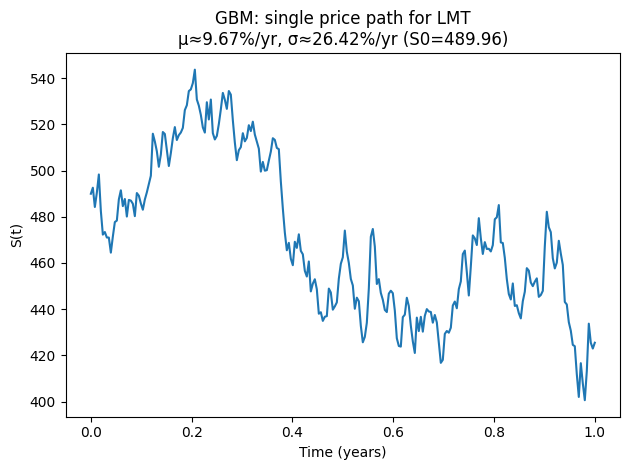

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


if 'lmt' not in globals():
    raise NameError("Series 'lmt' not found. Make sure you've run your close_series('LMT') cell.")

ann = 252  
r = np.log(lmt).diff().dropna()
mu_log_daily = r.mean()            
sigma_daily  = r.std(ddof=1)


sig_gbm = float(sigma_daily * np.sqrt(ann))
mu_gbm  = float(mu_log_daily * ann + 0.5 * sig_gbm**2)


S0 = float(lmt.iloc[-1])   
T_default = 1.0            
n_steps_default = ann      


T = T_default
n_steps = n_steps_default
dt = T / n_steps
t = np.linspace(0.0, T, n_steps + 1)


rng = np.random.default_rng(42)


S = np.empty(n_steps + 1)
S[0] = S0
for k in range(1, n_steps + 1):
    Zk = rng.standard_normal()
    incr = (mu_gbm - 0.5 * sig_gbm**2) * dt + sig_gbm * np.sqrt(dt) * Zk
    S[k] = S[k-1] * np.exp(incr)

plt.figure()
plt.plot(t, S)
plt.xlabel("Time (years)")
plt.ylabel("S(t)")
plt.title(f"GBM: single price path for LMT\nμ≈{mu_gbm:.2%}/yr, σ≈{sig_gbm:.2%}/yr (S0={S0:.2f})")
plt.tight_layout()
plt.show()


C:\Users\cesar\AppData\Local\Temp\ipykernel_24972\3761708549.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(lmt.iloc[-1])


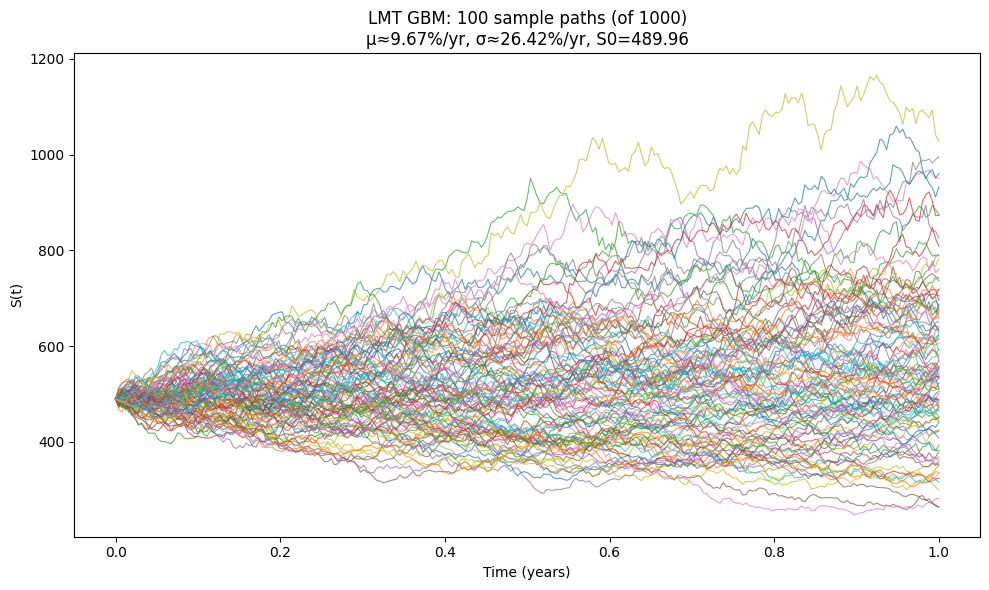

: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


if 'lmt' not in globals():
    raise NameError("Series 'lmt' not found. Run your close_series('LMT') cell first.")

ann = 252

if 'mu_gbm' not in globals() or 'sig_gbm' not in globals():
    r_lmt = np.log(lmt).diff().dropna()
    sigma_daily = r_lmt.std(ddof=1)
    mu_log_daily = r_lmt.mean()
    sig_gbm = float(sigma_daily * np.sqrt(ann))                  # annual vol
    mu_gbm  = float(mu_log_daily * ann + 0.5 * sig_gbm**2)       # annual drift


if 'T' not in globals():            T = 1.0             # years
if 'n_steps' not in globals():      n_steps = ann       # trading days
dt = T / n_steps
t = np.linspace(0.0, T, n_steps + 1)


S0 = float(lmt.iloc[-1])
if 'rng' not in globals():
    rng = np.random.default_rng(42)


n_paths = 1000
Z_mc = rng.standard_normal((n_paths, n_steps))
incr_mc = (mu_gbm - 0.5 * sig_gbm**2) * dt + sig_gbm * np.sqrt(dt) * Z_mc
log_S_paths = np.cumsum(incr_mc, axis=1)
log_S_paths = np.column_stack([np.zeros(n_paths), log_S_paths])
S_mc = S0 * np.exp(log_S_paths)


n_show = 100
plt.figure(figsize=(10,6))
for i in range(n_show):
    plt.plot(t, S_mc[i], alpha=0.7, linewidth=0.8)
plt.xlabel("Time (years)")
plt.ylabel("S(t)")
plt.title(f"LMT GBM: {n_show} sample paths (of {n_paths})\nμ≈{mu_gbm:.2%}/yr, σ≈{sig_gbm:.2%}/yr, S0={S0:.2f}")
plt.tight_layout()
plt.show()


The estimated parameters based on LMT's daily log-returns, we obtain an annual drift of approximatively μ ≈ 9.67%/year and an annual volatility of σ ≈ 26.42%/year. Using these results as parameters, 1000GBM paths were simulated over a one-year horizon starting from the current price $S_0=489.96$. The simulated trajectories show the typical log-normal dispersion of a Geometric Brownian Motion: most paths remain close to the initial price with a moderate upward drift while some exhibit stronger upward or downward movements due to volatility.

From our code we obtain two graphs. The first one *Single GBM Path* and the second one *Monte Carlo Simulation*. The first graph, illustrates one possible simulated trajectory of Lockheed stock price over one year period. The graph shows how random shocks can influence the evoluation of the asset price. The second graph, displays 100 of the 1000 simulated GBM paths, highlighting the wide range of potential outcomes driven by stochastic volatility.

When comparing these two simulations with the realised price path of LMT, we can see that the actual trajectory stays broadly within the dispersion range implied by the Monte Carlo simulations. This shows that the estimated drift and volatility provide reasonable fit. Nevertheless, our series exhibits volatility clustering and asymmetric movements that a constant-volatility GBM cannot capture.


# References:
- Campbell, J.Y., Lo, A.W. and MacKinlay, A.C. (1997) The Econometrics of Financial Markets. Princeton, NJ: Princeton University Press.
- Mandelbrot, B. (1963) ‘The Variation of Certain Speculative Prices’, The Journal of Business, 36(4), pp. 394–419.
- Tsay, R.S. (2010) Analysis of Financial Time Series. 3rd edn. Hoboken, NJ: John Wiley & Sons.

